In [1]:
import cv2 as cv
import h5py
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import openslide
import pandas as pd
import random
from PIL import Image

import os

In [2]:
# Paths to raw TMA files.
PATH_TO_RAW_DATA = "/deep/group/aihc-bootcamp-fall2021/lymphoma/raw"
PATH_TO_IMAGES = os.path.join(PATH_TO_RAW_DATA, "svs")

# Path to processed data (extracted TMA patches)
PATH_TO_PROCESSED_DATA = "/deep/group/aihc-bootcamp-fall2021/lymphoma/processed"
PATH_TO_TMA_PATCHES = os.path.join(PATH_TO_PROCESSED_DATA, "tma_patches")

# Path to annotations and labels (diagnoses)
PATH_TO_ANNOTATIONS_CSV = os.path.join(PATH_TO_RAW_DATA, "cores")
PATH_TO_DIAGNOSES = os.path.join(PATH_TO_RAW_DATA, "core_labels.csv")

In [3]:
# ID of TMA being processed
TMA_ID = 6

# Path to generated annotations file from *_annotations.qpdata files
PATH_TO_TMA_ANNOTATION = os.path.join(PATH_TO_ANNOTATIONS_CSV, "TMA6B_annotations.csv")

# Path to *TMA*.svs
PATH_TO_TMA_IMAGE = os.path.join(PATH_TO_IMAGES, "1010906_TMA6B.svs")

In [4]:
tma = openslide.OpenSlide(PATH_TO_TMA_IMAGE)
tma_annotations = pd.read_csv(PATH_TO_TMA_ANNOTATION)
tma_annotations.head()

Name        X        Y   Width  Height
0  E0850B  49174.0  37725.0  3032.0  3032.0
1  E0867A  45448.0  29136.0  3032.0  3032.0
2  E0829B   2632.0  47955.0  3031.0  3031.0
3  E0870B  24608.0  28378.0  2779.0  2779.0
4  E0921B  21577.0   6907.0  3031.0  3031.0

In [5]:
tma_case_to_diagnosis = pd.read_csv(PATH_TO_DIAGNOSES)
tma_case_to_diagnosis.head()

Unnamed: 0  TMA ID     CASE                  2017 WHO DIAGNOSIS  \
0           0       1  E0001 B                          NOT ON TMA   
1           1       1  E0002 B                      NON-DIAGNOSTIC   
2           2       1  E0003 B            Classic Hodgkin Lymphoma   
3           3       1  E0004 B      Follicular lymphoma, grade 1-2   
4           4       1  E0005 B  Diffuse large B cell lymphoma, NOS   

  CLPA Diagnostic Bin  label  
0            Excluded     -1  
1            Excluded     -1  
2                  HL      1  
3                  FL      3  
4               DLBCL      0

In [6]:
print(len(tma_case_to_diagnosis[tma_case_to_diagnosis["TMA ID"] == TMA_ID]))
print(len(tma_annotations))

229
192


In [7]:
# Taken from DLBCL-Morph: extracting_roi_tma.ipynb.
# Takes in a patch (PIL image) and returns whether or not the patch is sufficiently non-white.
def is_patch_nonwhite_first(patch):
    PERCENT_WHITE_PIXELS_THRESHOLD = 0.95
    SAT_THRESHOLD = 0.05

    hsv_patch = matplotlib.colors.rgb_to_hsv(patch)
    saturation = hsv_patch[:,:,1]
    percent = np.mean(saturation < SAT_THRESHOLD)
    return percent <= PERCENT_WHITE_PIXELS_THRESHOLD

# Taken from DLBCL-Morph: extracting_roi_tma.ipynb.
# Takes in a patch (PIL image) and returns whether or not the patch is sufficiently non-white.
def is_patch_nonwhite_second(patch):
    GRAD_ZERO_THRESHOLD = 500
    gray = cv.cvtColor(np.array(patch), cv.COLOR_RGB2GRAY)
    sobelx = cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=5)
    sobely = cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=5)
    mag = np.abs(sobelx) + np.abs(sobely)
    return np.sum(mag == 0) <= GRAD_ZERO_THRESHOLD

# Extracts (default: 224 x 224) patches from a single core in the passed-in TMA.
# The tissue core is defined by: top-left: (xs, ys), bottom-right: (xe, ye).
# Only patches that are sufficiently non-white are returned.
# Returns an np.array of dimension: n x 224 x 224 x 3 (where n = # of returned patches)
def get_patches_from_core(tma, xs, ys, xe, ye, patch_size=224):
    patches = []
    for y in range(ys, ye, patch_size):
        for x in range(xs, xe, patch_size):
            patch = tma.read_region([x, y], 0, [patch_size, patch_size]).convert('RGB')
            if is_patch_nonwhite_first(patch) and is_patch_nonwhite_second(patch):
                patches.append(np.array(patch))
                
    if len(patches) == 0:
        return np.array([])
    return np.stack(patches)

In [8]:
CASE = "CASE"
DIAGNOSIS = "2017 WHO DIAGNOSIS"

def get_diagnosis_by_patient_id(tma_id, patient_id):
    missing_ids = set(["placenta", "tonsil"])
    
    print(patient_id)
    
    if patient_id in missing_ids:  # Do not consider placenta/tonsils
        print(f"Could not find diagnosis for: {patient_id}")
        return "None"
    elif not patient_id.rstrip()[-2].isspace() and patient_id.rstrip()[-1].isalpha():  # Add space between alphabet and number: "E0456B" -> "E0456 B"
        patient_id = patient_id[:-1] + " " + patient_id[-1]
        
    condition = (tma_case_to_diagnosis[CASE] == patient_id) & (tma_case_to_diagnosis["TMA ID"] == tma_id)
    
    if len(tma_case_to_diagnosis[condition][DIAGNOSIS].values) == 0:
        print(f"Could not find diagnosis for: {patient_id}")
        return "None"
    
    return tma_case_to_diagnosis[condition][DIAGNOSIS].values[0]

print(get_diagnosis_by_patient_id(1, "E0090 C"))
print(get_diagnosis_by_patient_id(4, "E0456 B"))

E0090 C
NON-DIAGNOSTIC
E0456 B
Diffuse large B cell lymphoma, non-germinal center type


In [9]:
def tma_to_hdf5_file(tma_id, tma_annotations, tma_slide):
    tma_hdf5_filename = os.path.join(PATH_TO_TMA_PATCHES, f'tma{tma_id}.hdf5')
    if os.path.exists(tma_hdf5_filename):
        os.remove(tma_hdf5_filename)
    f = h5py.File(tma_hdf5_filename, "w")
    patient_ids = set()
    
    patient_id_repeats = {}
    
    for index, row in tma_annotations.iterrows():
        patient_id = row["Name"]
        
        if not isinstance(patient_id, str):
            continue
        
        name = patient_id
        
        diagnosis = get_diagnosis_by_patient_id(tma_id, patient_id)
        
        if diagnosis == "None":
            continue
        
        # Deal with duplicate patients
        if (patient_id not in patient_ids):
            patient_id_repeats[patient_id] = 0

        patient_id_repeats[patient_id] += 1
        name += f"_v{patient_id_repeats[patient_id]}"
            
        xs, ys, width, height = int(row["X"]), int(row["Y"]), int(row["Width"]), int(row["Height"])
        xe, ye = xs + width, ys + height
        patches = get_patches_from_core(tma_slide, xs, ys, xe, ye)
        
        if patches.size == 0:
            continue
        
        dset = f.create_dataset(name, data=patches, dtype='uint8')
        dset.attrs['patient_id'] = patient_id
        dset.attrs['diagnosis'] = diagnosis
        patient_ids.add(patient_id)
        
    f.close()
    
tma_to_hdf5_file(TMA_ID, tma_annotations, tma)

E0850B
E0867A
E0829B
E0870B
E0921B
E0851B
E0859B
E0848C
E0878B
E0903B
E0833B
E0850B
E0919B
E0857B
E0893B
E0832B
E0843B
E0888A
E0931B
E0831B
E0928B
E0887B
placenta
Could not find diagnosis for: placenta
E0894B
E0829B
E0865B
E0897B
E0184
Could not find diagnosis for: E0184
E0909B
E0901C
E0866B
E0892B
E0917B
E0905B
E0831B
E0889
E0883B
E0868B
E0861B
E0891B
E0924B
E0932B
E0853B
E0919B
E0873B
E0905B
E0890B
E0839B
E0873B
E0860B
E0907B
E0890B
E0888A
E0833B
E0926B
E0880B
E0876B
E0908B
E0846B
placenta
Could not find diagnosis for: placenta
E0842B
E0908B
E0872B
E0851B
E0862B
E0932B
E0921B
E0920B
E0835B
E0883B
E0924B
E0884
E0926B
E0840A
E0855A
E0826B
E0917B
E0859B
E0915B
E0871B
E0867A
tonsil
Could not find diagnosis for: tonsil
E0878B
E0874B
E0892B
E0920B
E0842B
E0843B
E0834B
E0841B
E0147
Could not find diagnosis for: E0147
E0895B
E0865B
E0137
Could not find diagnosis for: E0137
E0889
E0868B
E0849A
E0887B
E0879A
E0832B
E0830B
E0893B
E0881B
E0925B
E0836B
E0864B
E0891B
E0834B
E0925B
E0858B
E0930A
E0

In [10]:
def get_patches_by_patient_id(tma_name, patient_id):
    tma_hdf5_filename = PATH_TO_TMA_PATCHES + f"/{tma_name}.hdf5"
    f = h5py.File(tma_hdf5_filename, "r")
    if patient_id not in f:
        f.close()
        assert(f"Patient ID: {patient_id} not in {tma_name}")
    dset = f[patient_id]
    print("Patient ID: ", patient_id)
    print("Diagnosis: ", dset.attrs['diagnosis'])
    patches_array = np.zeros(dset.shape, dtype='uint8')
    dset.read_direct(patches_array)
    f.close()
    return patches_array

def get_random_patch(patches_array):
    i = random.randint(0, patches_array.shape[0])
    patch = patches_array[i,:]
    return Image.fromarray(patch)

def show_patches(patches_array, num_samples=None):
    n = patches_array.shape[0]
    if num_samples != None:
        n = min(n, num_samples)
    for i in range(n):
        plt.imshow(patches_array[i])
        plt.show()

Patient ID:  E0003 B
Diagnosis:  Classic Hodgkin Lymphoma
Number of patches extracted:  121


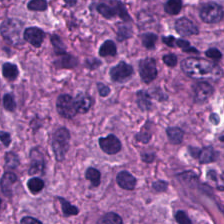

In [11]:
# Extract patches for patient ID: E0003 B.

patches_array = get_patches_by_patient_id("tma1", "E0003 B")
print("Number of patches extracted: ", len(patches_array))
image = get_random_patch(patches_array)
image

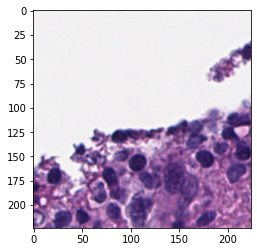

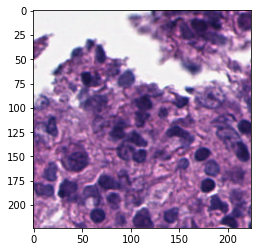

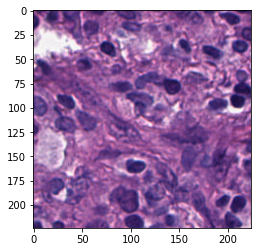

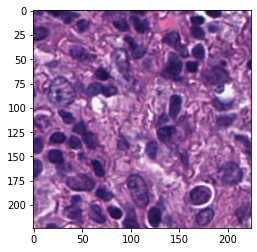

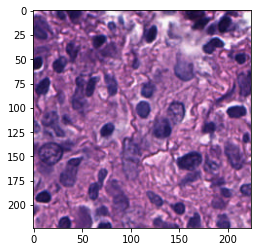

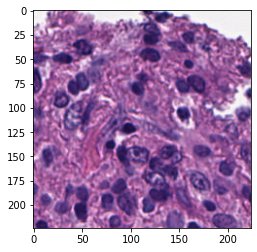

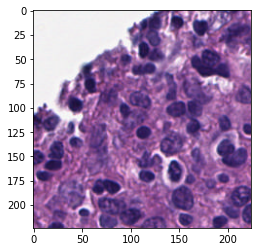

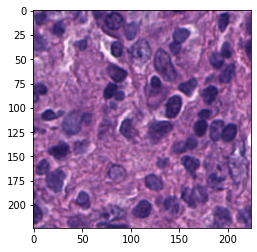

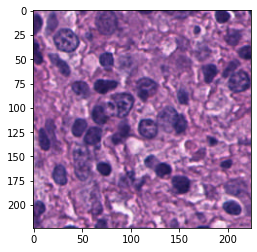

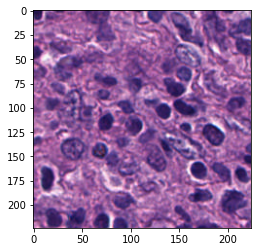

In [12]:
show_patches(patches_array, num_samples=10)

## Testing

In [13]:
# These values are obtained from 1010900_TMA1_annotated.qpdata.
xs = 13046
ys = 6695
width = 2699
height = 2813

xe = xs + width
ye = ys + height

In [14]:
patch = tma.read_region([xs, ys], 0, [width, height]).convert('RGB')

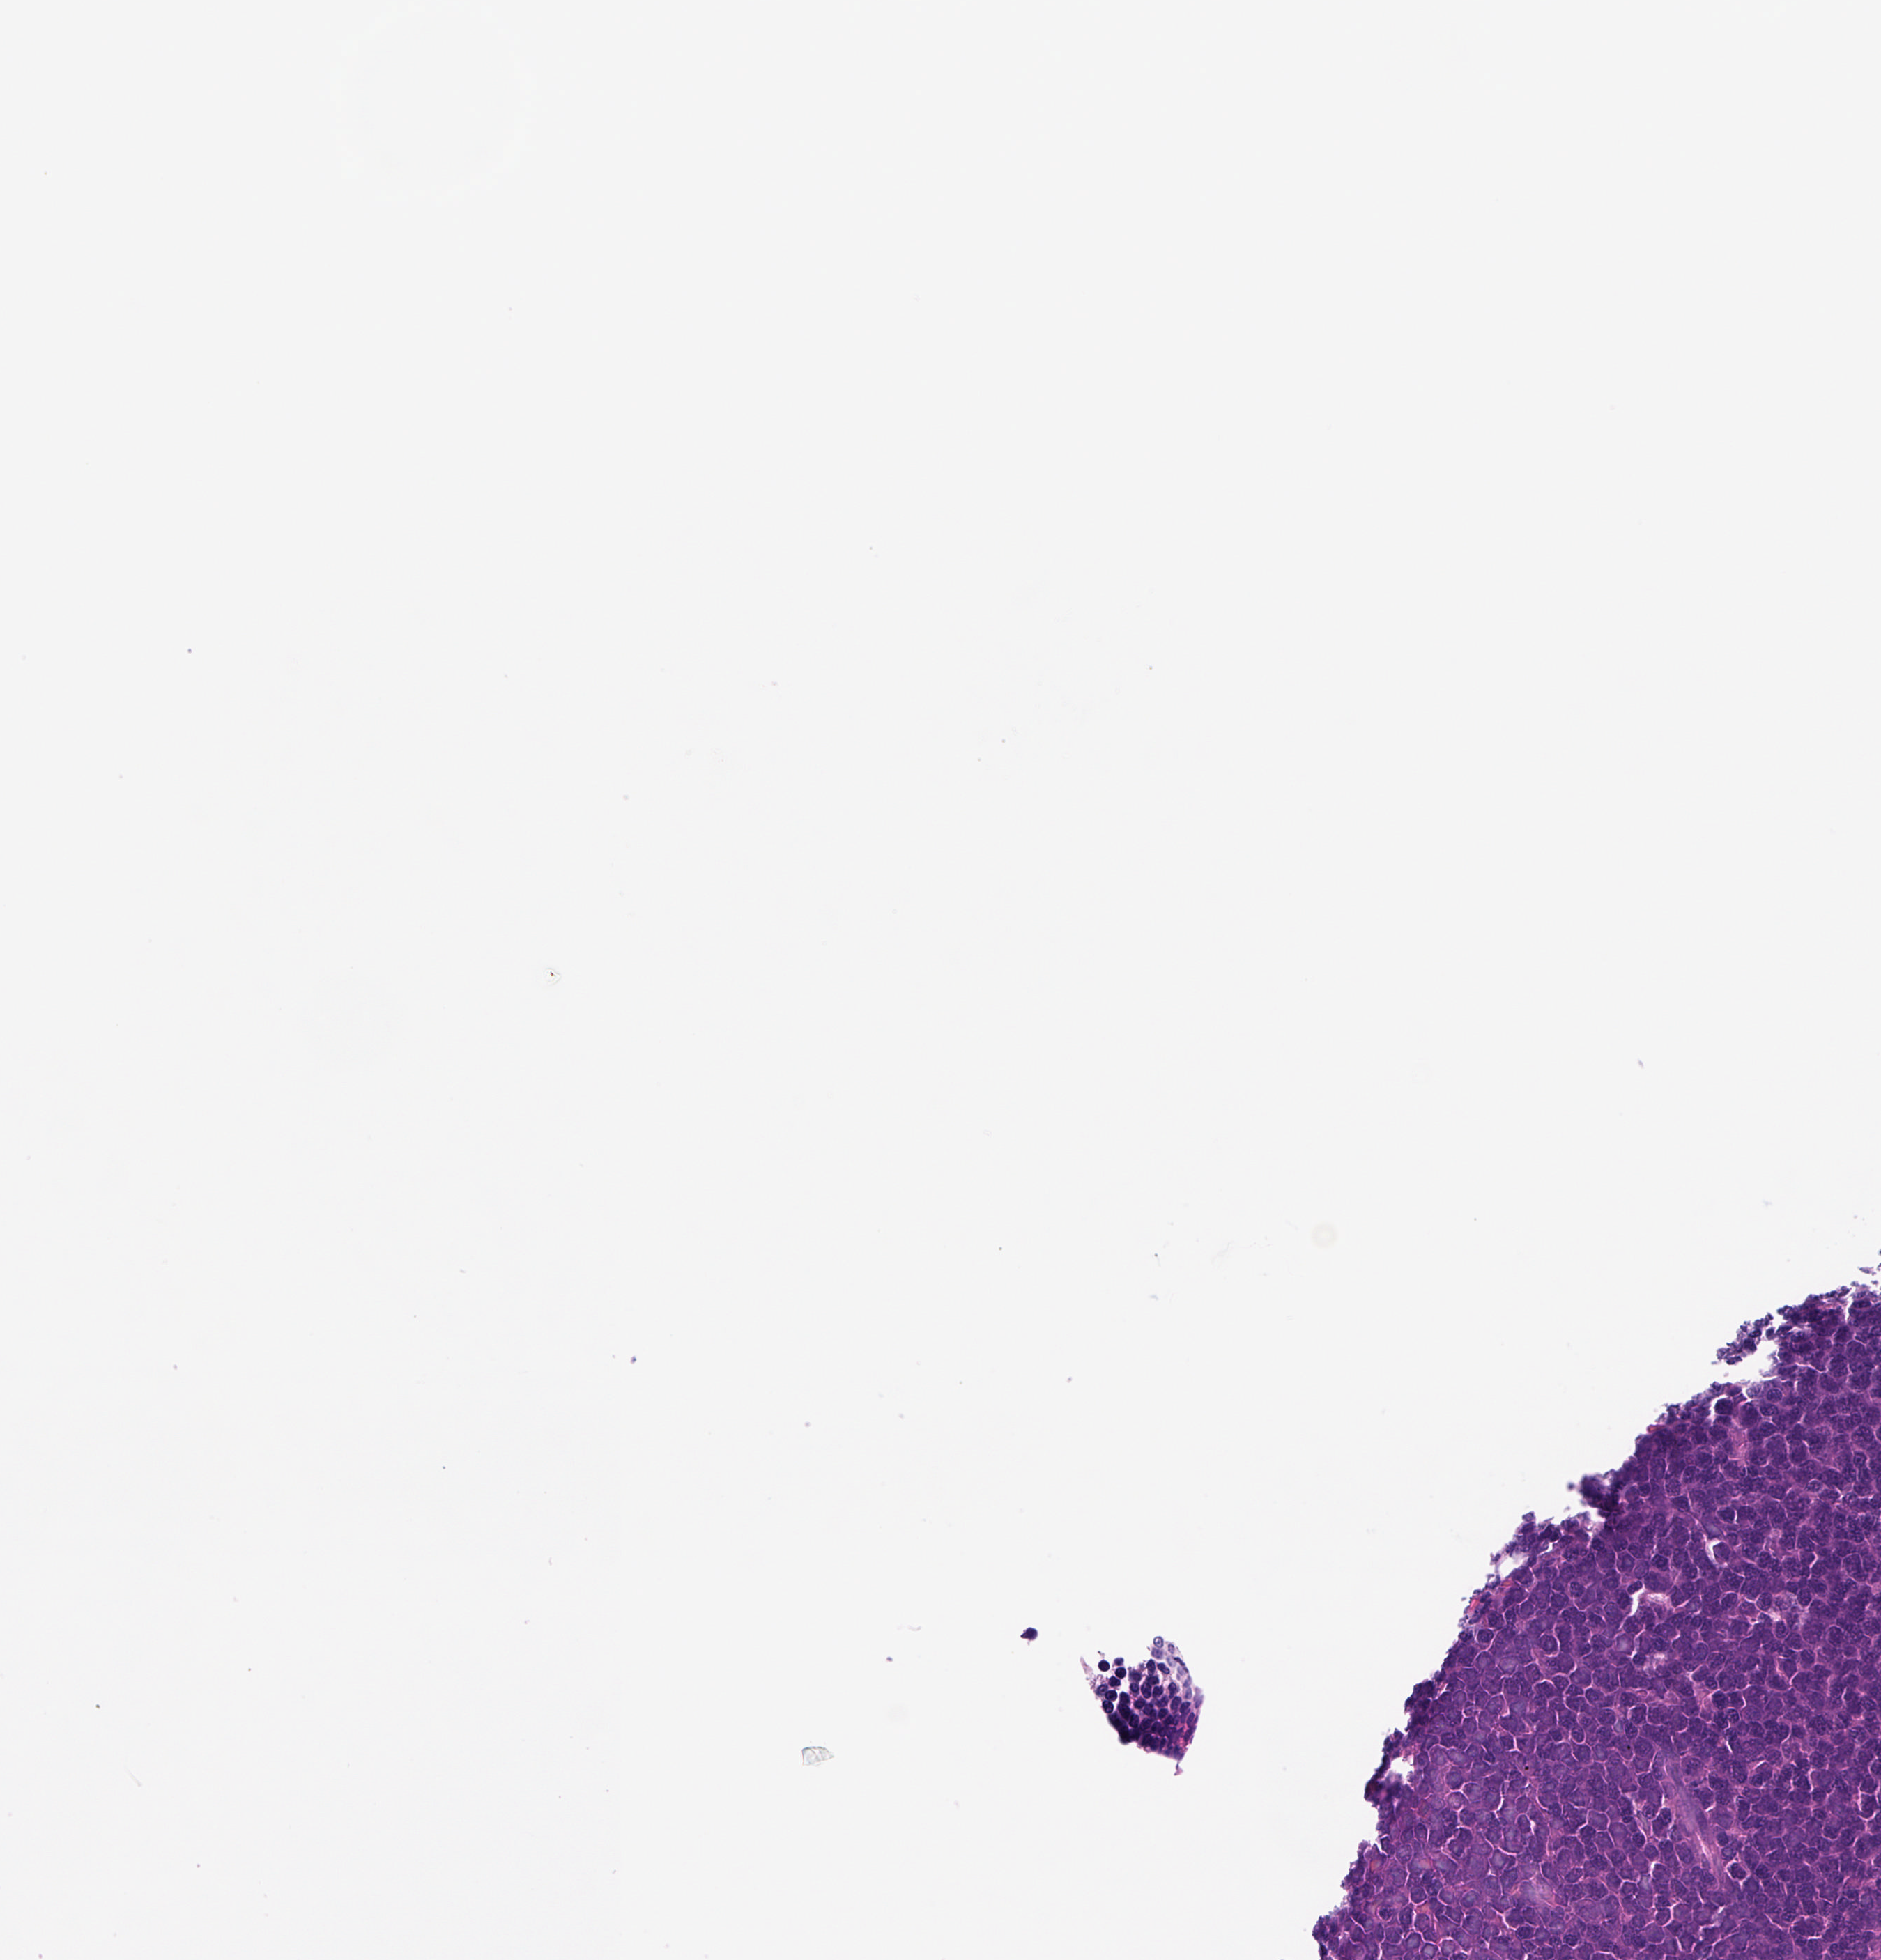

In [15]:
patch

In [16]:
patches = get_patches_from_core(tma, xs, ys, xe, ye)
num_patches = len(patches)
print(f"Number of patches extracted: {num_patches}")

Number of patches extracted: 14


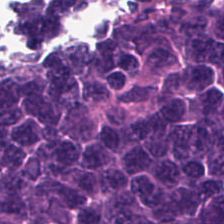

In [17]:
patch = patches[0,:]
image = Image.fromarray(patch)
image